# Deep Learning &mdash; Assignment 11

Assignment for week 11 of the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_November 2022_

-----

**Names:** Hauque, Federico Gabriel - Soler Sanz, Guillem

**Group:** 5

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a graph neural network, using pytorch geometric
2. Compare a GNN with other network architectures
3. Compare different GNN layers and aggregation functions

## Required software

As before you will need these libraries:
* `torch`, `torch-sparse`, `torch-scatter`, and `torch-geometric` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

The recommended way to install these libraries is described in the [torch-geometric installation instructions](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [ ]:
# Replace ${TORCH} and ${CUDA} with your torch and cuda versions.
# Or remove the -f argument to compile from source
#
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 8.9 MB 7.5 MB/s 
     |████████████████████████████████| 3.5 MB 2.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 7.3 MB/s 
     |████████████████████████████████| 280 kB 35.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=de21b42f9eeb27d9452568f041c53571855c3796adb8c63c3387867fbc2e5489
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
!pip install d2l==1.0.0a1.post0
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch import nn
from torch.nn import Linear, Dropout
from torch.nn import functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 121 kB 46.2 MB/s 
     |████████████████████████████████| 1.6 MB 60.5 MB/s 
     |████████████████████████████████| 83 kB 2.5 MB/s 


## 11.1 A node classification dataset (1 point)

In this assignment we will be working on a node classification problem using the Citeseer dataset. This is a graph dataset that contains bag-of-words representation of documents and citation links between the documents. So there is an edge between document $i$ and document $j$ if one cites the other. This is an undirected edge.

In [ ]:
dataset = Planetoid(root='data', name='Citeseer', transform=NormalizeFeatures())

Processing...
Done!


**(a) How many graphs are there in this dataset? How large are they (in terms of nodes and edges)?<span style="float:right"> (1 point)</span>**

In [ ]:
print(f'Number of graphs: {len(dataset)}')
print(f'Size of graphs: {len(dataset[0].x)}')

Number of graphs: 1
Size of graphs: 3327


In fact, we will continue the rest of this notebook using the first graph from the dataset.

In [ ]:
data = dataset[0]  # Get the first graph object.

We will be use a subset of the nodes for training, and another subset for testing.
These subsets are indicated by `data.train_mask` and `data.test_mask` respectively.

## 11.2 MLP for node classification (6 points)

In theory, we should be able to classify documents based only on their content, that is, using the bag-of-words features, without taking the graph structure into account.

We can verify that by constructing a simple node-wise multilayer perceptron with a single hidden layer. This network does not use the edge information at all.

**(a) Complete the code below.<span style="float:right"> (2 points)</span>**

The network should have 2 linear layers. The hidden layer should have size `hidden_channels`, use ReLU activations, and use dropout with a dropout rate of 0.5. Don't use an activation function after the final layer.

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels = 16):
        super().__init__()
        self.net = torch.nn.Sequential(
          nn.Linear(num_features, hidden_channels), nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(hidden_channels, num_classes))

    def forward(self, x, edge_index):
        return self.net(x)

**(b) Complete the training loop below.<span style="float:right"> (2 points)</span>**

Hint: compute the loss only on the training nodes.

Hint 2: `data.x` contains the features for each node, `data.y` contains their labels.

Hint 3: `model()` takes two parameters: a tensor of node features, and a tensor of edges. See the `test_accuracy` function.

In [ ]:
def accuracy(pred_y, true_y):
    correct = pred_y.argmax(dim=1) == true_y
    return int(correct.sum()) / len(true_y)

def test(model, data):
    loss_fn = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        model.eval()
        out = model(data.x, data.edge_index)
        # Compute loss and accuracy only on the 'test' nodes
        test_loss = loss_fn(out[data.test_mask], data.y[data.test_mask]).item()
        test_acc = accuracy(out[data.test_mask], data.y[data.test_mask])
        # Compute loss and accuracy only on the 'train' nodes
        train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask]).item()
        train_acc = accuracy(out[data.train_mask], data.y[data.train_mask])
        return train_loss, train_acc, test_loss, test_acc

def train(model, data, lr=0.01, weight_decay=5e-4, epochs=400, plot=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()
    if plot:
        animator = d2l.Animator(xlabel='epoch', xlim=[1, epochs], figsize=(10, 5),
                                legend=['train loss', 'train accuracy', 'test loss', 'test accuracy'])
    
    for epoch in range(1, epochs+1):
        model.train()
        # TODO: Compute and optimize loss
        res = model(data.x, data.edge_index)
        loss_res = loss_fn(res[data.train_mask], data.y[data.train_mask])
        train_loss = loss_res.item()
        train_acc = accuracy(res[data.train_mask], data.y[data.train_mask])
        optimizer.zero_grad()
        loss_res.backward()
        optimizer.step()

        # Compute test accuracy, and plot
        if plot and epoch % 10 == 0:
            train_loss, train_acc, test_loss, test_acc = test(model, data)
            animator.add(epoch + 1, (train_loss, train_acc, test_loss, test_acc))
    
    # Print final accuracy
    train_loss, train_acc, test_loss, test_acc = test(model, data)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

**(c) Now construct and train an MLP on this dataset.<span style="float:right"> (1 point)</span>**

Train loss: 0.0886, Train accuracy: 1.0000
Test loss: 1.2184, Test accuracy: 0.5790


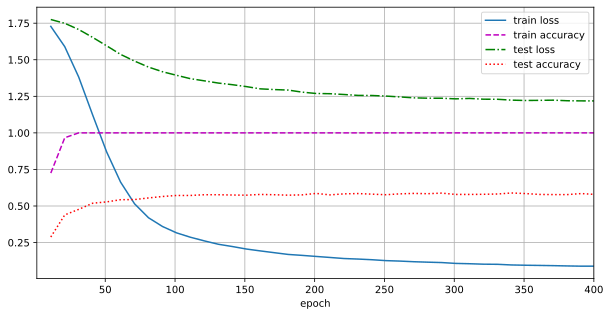

In [ ]:
# TODO: construct and train the model
mlp_model = MLP(3703, 6)
train(mlp_model, data)

**(d) The MLP network does not use the citation information at all. Give a way to incorporate the edge information without using a graph neural network?<span style="float:right"> (1 point)</span>**

We could perform an operation over the nodes to encode their related edges, just like we did with positional encoding, but not aiming to save a position in a sequence, but a defined edge relation. This could be done with and adjacency or laplacian matrix.

## 11.3 A graph convolutional neural network (3 points)

Next, we will use a graph neural network based on the Graph Convolutional Network approach, which was introduced in the paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf).

**(a) Implement a graph convolutional neural network, by replacing the linear layers in the MLP with [`GCNConv` layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), and train the network.<span style="float:right"> (1 point)</span>**

The network should have two `GCNConv` layers. The rest of the architecture should stay as close as possible to the MLP.

Train loss: 0.1967, Train accuracy: 1.0000
Test loss: 0.9393, Test accuracy: 0.7120


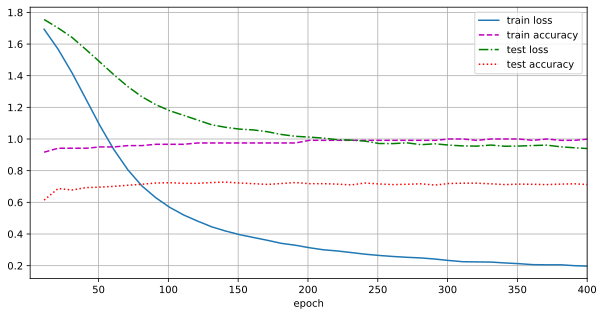

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels = 16):
        super().__init__()
        self.gnc_conv1 = GCNConv(num_features, hidden_channels)
        self.gnc_conv2 = GCNConv(hidden_channels, num_classes)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
            

    def forward(self, x, edge_index):
        x = self.gnc_conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.gnc_conv2(x, edge_index)
        return  x

# TODO: construct and train the model
gcn_model = GCN(3703, 6)
train(gcn_model, data)

**(b) Compare the results of the MLP and the GCN. Which model is better?<span style="float:right"> (1 point)</span>**

The GCN achieves a lower generalization gap since the difference between training and testing a ccuracy is significantly lower, while the test loss has alsodecreased considerably. Therefore, it is reasonable to say that the GCN outperforms the MLP.

**(c) Has the GCN training converged? Can you expect higher test accuracies by training longer? Explain your answer.<span style="float:right"> (1 point)</span>**

Although the test loss was still slowily decreasing when the last epoch was executed, the tets accuracy did not seem to change much in the latest epochs, menaing that it should have achieved convergence and no further training would alter the metrics significantly.

## 11.4 Comparing GNN layers (8 points)

Two graph layer that are interesting to compare are [`SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) and [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv). Aside from one of them supporting weighted graphs, these models differ only in the accumulation function.

**(a) Look at the documentation for these two layers. What is the difference in the accumulation function?<span style="float:right"> (1 point)</span>**

The difference is that one of the layers accumulate the mean of all the nodes in the neighbourhood ignorin any weights thta might be present in the edges.Wherease the other layer accumulates the sum of all the nodes multiplied by the weights of the edges that connect those nodes with the current one.

To avoid having to copy the GNN structure every time, we can make our code generic in the type of layer to use.

**(b) Make a generic graph neural network, that uses layers of type `layer_type`.<span style="float:right"> (1 point)</span>**

Hint: you can construct layers with `my_layer = layer_type(in_size, out_size, **layer_args)`.

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, layer_type, num_features, num_classes, hidden_channels=16, **layer_args):
        super().__init__()
        self.conv1 = layer_type(num_features, hidden_channels, **layer_args)
        self.conv2 = layer_type(hidden_channels, num_classes, **layer_args)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return  x

**(c) Train a SAGEConv network and a GraphConv network.<span style="float:right"> (no points)</span>**

Train loss: 0.0465, Train accuracy: 1.0000
Test loss: 0.9375, Test accuracy: 0.6890


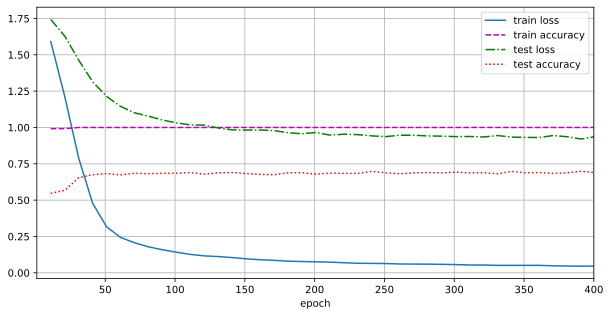

In [ ]:
# TODO: construct and train a GNN with SAGEConv layers
sageconv_model = GNN(SAGEConv, 3703, 6)
train(sageconv_model, data)

Train loss: 0.0195, Train accuracy: 1.0000
Test loss: 1.2669, Test accuracy: 0.6800


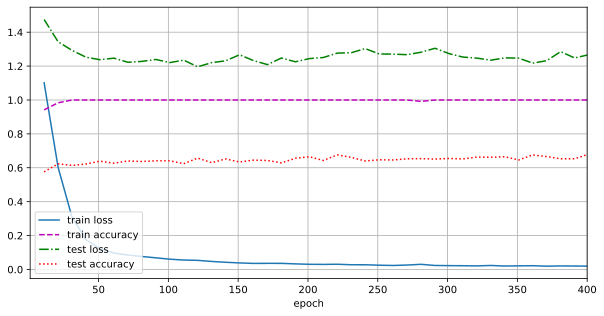

In [ ]:
# TODO: construct and train a GNN with GraphConv layers
graphconv_model = GNN(GraphConv, 3703, 6)
train(graphconv_model, data)

**(d) Compare the performance of these two models, and also compare them to the GCN.<span style="float:right"> (1 point)</span>**

Hint: look at the test loss.

Both models are extremely overfitted, SAGEConv has a significantly lower test loss, but not much different to the previous GCN. Both training and testing accuracies as well as teh generalization gaps remain extremely similar, though they seem to be outperformed by GCNs.
The test loss however show a significant difference, having an unstable behaviour with higehr values with the GraphConv than with the SAGEConv.

**(e) Can you explain the observation in the previous question by looking at the aggregation functions? Why is one of them worse than the others?<span style="float:right"> (1 point)</span>**

Computing a sum of the neighbours is not going to be as effective as a mean of them, since the mean has a lower error diference to the set of neighbour values, so it represents the whole set better. Also, the GraphConv network is intended to compute edge weights (which we do not have) and the whole operation results in a simple sum of node values instead of a weighted sum, which would have been more exact.

In fact, it is possible to use different aggregation functions, by passing `aggr=` to the network constructor.

**(f) Compute the performance for `GraphConv` networks with `'mean'`, `'sum'`, `'min'`, `'max'`, and `'std'` aggregation.<span style="float:right"> (1 point)</span>**

Hint: train with `plot=False` to only show the final loss and accuracy.

Hint 2: if the performance is the same for all methods, there is most likely a bug in your `GNN` code.

In [ ]:
for fun in ['mean', 'sum', 'min', 'max', 'std']:
  print("Aggregation function: ", fun)
  graphconv_model = GNN(GraphConv, 3703, 6, aggr=fun)
  train(graphconv_model, data, plot=False)

Aggregation function:  mean
Train loss: 0.0490, Train accuracy: 1.0000
Test loss: 0.9447, Test accuracy: 0.7030
Aggregation function:  sum
Train loss: 0.0193, Train accuracy: 1.0000
Test loss: 1.3152, Test accuracy: 0.6580
Aggregation function:  min
Train loss: 0.0608, Train accuracy: 1.0000
Test loss: 1.0855, Test accuracy: 0.6570
Aggregation function:  max
Train loss: 0.0454, Train accuracy: 1.0000
Test loss: 1.0378, Test accuracy: 0.6530
Aggregation function:  std
Train loss: 0.1216, Train accuracy: 1.0000
Test loss: 1.1284, Test accuracy: 0.6450


**(g) Which three aggregation methods are the worst? For each one, explain why that one would not work well.<span style="float:right"> (3 points)</span>**

Hint: bag-of-word features are very sparse.

The worst aggregation methods are std, max and min. This is expected since the graphs represent a set of bag of words features  in which we only have a 0/1 relation between cited papers. Since these types of features are very sparse, the std, max and min values are not good representatives of the set of neighbors because their values are significanlty different fron the rest. The mean approach is still overfitting, but considerably better, achieving a decent 0,70 accuracy.


## 11.5 Discussion (3 points)

**(a) Our training procedure gets the entire graph, including test nodes. Is it possible for the model to cheat using leaked information?<span style="float:right"> (1 point)</span>**

No, because although the model gest the whole graph, the loss function is optimized using the training nodes only, and later evaluated on the testing ones.

**(b) Can the GCN and GNN networks use information from neighbors of neighbors to classify a node? Briefly explain your answer.<span style="float:right"> (1 point)</span>**

Yes, as explained in the paper, the grpah convolution operation is derived from a spectral convolution that can be applied to a Kth order path between nodes instead of just relying on the direct adjacent neighbors.

**(c) Do you think the trained model will generalize to other networks? Motivate your answer.<span style="float:right"> (1 point)</span>**

The model appears to be considerably overfitted in all the performed tests, so we cannot expect a good generalization for other graphs, though it is very likely that most other models achieve poor results due to the sparsity of teh bag of words features.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 21 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 9516ef3 / 2022-11-30</span>